In [32]:
# ==========================================
# 1. Imports
# ==========================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
# ==========================================
# 2. Load Data
# ==========================================
splits = {'train': 'data/train-00000-of-00001-2d193952f0849bbc.parquet', 'test': 'data/test-00000-of-00001-fb3536c9c871f904.parquet'}
df = pd.read_parquet("hf://datasets/fazni/roles-based-on-skills/" + splits["train"])



In [34]:
df.head()

,Role,text,label,__index_level_0__
0,Mobile App Developer,Java JavaScript Android Development PHP HTML S...,6,2480
1,Machine Learning Engineer,Python Programming Language SQL Machine Learni...,5,3525
2,Network Engineer,MySQL Shell Scripting Linux Ubuntu Windows Net...,7,2281
3,Business Analyst,Java Project Management Microsoft Office HTML ...,0,1293
4,DevOps,PostgreSQL Teamwork Microsoft Azure Amazon Web...,4,3178


Missing values per column:
 Role                 0
text                 0
label                0
__index_level_0__    0
dtype: int64


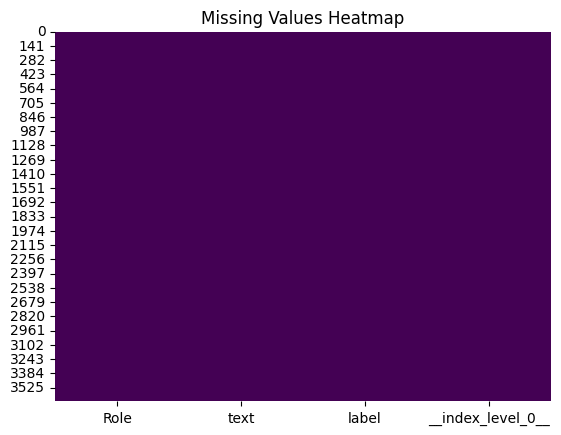

In [35]:
# Missing values
missing_counts = df.isna().sum()
print("Missing values per column:\n", missing_counts)

# Visualize missing values
sns.heatmap(df.isna(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

Role
Software Engineer            521
Quality Assurance            403
Machine Learning Engineer    399
Network Engineer             391
Business Analyst             387
DevOps                       378
Data Science                 332
Cyber Security               315
Mobile App Developer         314
Data Engineer                220
Name: count, dtype: int64


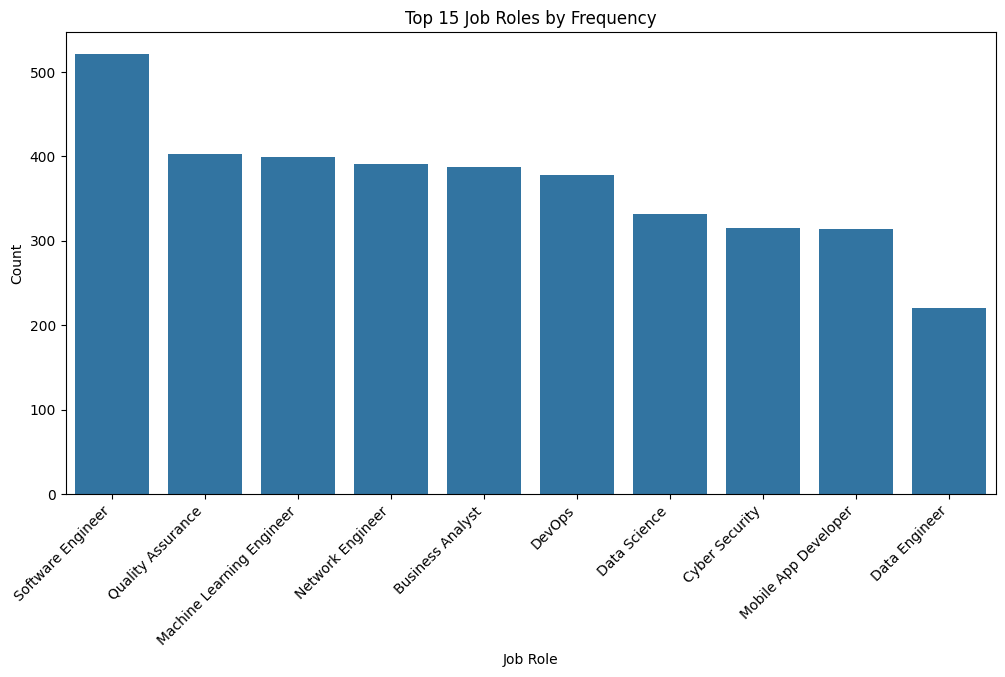

In [36]:
# Count of each job role
role_counts = df['Role'].value_counts()
print(role_counts.head(10))  # top 10 roles

# Bar plot
plt.figure(figsize=(12,6))
sns.barplot(x=role_counts.index[:15], y=role_counts.values[:15])
plt.xticks(rotation=45, ha='right')
plt.title("Top 15 Job Roles by Frequency")
plt.ylabel("Count")
plt.xlabel("Job Role")
plt.show()

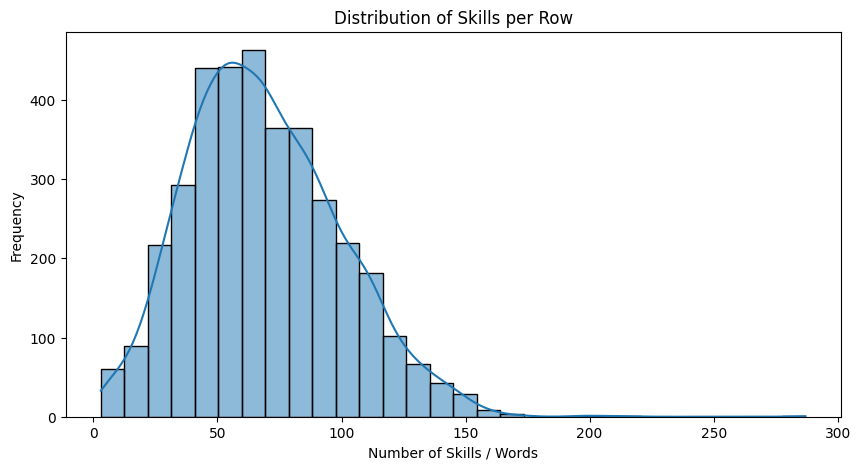

In [37]:
df['text_length'] = df['text'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title("Distribution of Skills per Row")
plt.xlabel("Number of Skills / Words")
plt.ylabel("Frequency")
plt.show()

In [38]:
# Jobs with <5 examples
rare_jobs = df['Role'].value_counts()[df['Role'].value_counts() < 5]
print(f"Number of rare jobs (<5 examples): {len(rare_jobs)}")

Number of rare jobs (<5 examples): 0


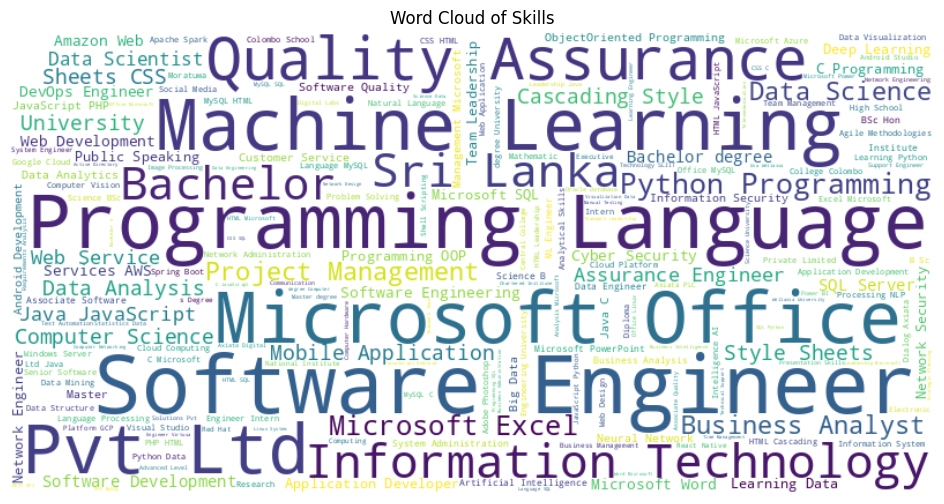

In [39]:
all_skills = " ".join(df['text'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_skills)

plt.figure(figsize=(15,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Skills")
plt.show()

In [40]:
# ==========================================
# 3. Prepare Data
# ==========================================
# Remove missing values
df = df.dropna(subset=['text', 'Role'])

texts = df['text'].astype(str).tolist()
labels = df['Role'].astype(str).tolist()

In [41]:
# ==========================================
# 4. Label Encoding
# ==========================================
le = LabelEncoder()
y = le.fit_transform(labels)
num_classes = len(le.classes_)
print(f"Number of job categories: {num_classes}")

Number of job categories: 10


In [42]:
# ==========================================
# 5. Tokenization & Padding
# ==========================================
MAX_NUM_WORDS = 10000     # vocabulary size
MAX_SEQ_LEN = 50          # adjust depending on avg skill list length

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
X = tokenizer.texts_to_sequences(texts)
X = pad_sequences(X, maxlen=MAX_SEQ_LEN, padding='post')

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [43]:
# ==========================================
# 6. BiLSTM Model
# ==========================================
EMBEDDING_DIM = 200

model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQ_LEN),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, MAX_SEQ_LEN))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 50, 200)        │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_5             │ (None, 50, 200)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 50, 256)        │       336,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,519,050 (9.61 MB)

 Trainable params: 2,519,050 (9.61 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# ==========================================
# 7. Training
# ==========================================
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 40s 682ms/step - accuracy: 0.1558 - loss: 2.2686 - val_accuracy: 0.4693 - val_loss: 1.6588
Epoch 2/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 40s 656ms/step - accuracy: 0.4229 - loss: 1.5337 - val_accuracy: 0.7048 - val_loss: 0.8486
Epoch 3/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 670ms/step - accuracy: 0.6906 - loss: 0.8552 - val_accuracy: 0.7918 - val_loss: 0.6275
Epoch 4/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 24s 646ms/step - accuracy: 0.7986 - loss: 0.5658 - val_accuracy: 0.8259 - val_loss: 0.5693
Epoch 5/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 23s 611ms/step - accuracy: 0.8641 - loss: 0.4319 - val_accuracy: 0.8567 - val_loss: 0.5420
Epoch 6/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 42s 646ms/step - accuracy: 0.9005 - loss: 0.3520 - val_accuracy: 0.8788 - val_loss: 0.4159
Epoch 7/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 24s 650ms/step - accuracy: 0.9297 - loss: 0.2535 - val_accuracy: 0.8771 - val_loss: 0.4822
Epoch 8/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 24s 643ms/step - accuracy: 0.9375 - loss: 0.2279 - val_accu

In [49]:
# ==========================================
# 8. Evaluation
# ==========================================
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {acc*100:.2f}%")


✅ Test Accuracy: 90.03%


In [50]:
# ==========================================
# 9. Predict Example
# ==========================================
def predict_job(skill_text):
    seq = tokenizer.texts_to_sequences([skill_text])
    padded = pad_sequences(seq, maxlen=MAX_SEQ_LEN, padding='post')
    pred = model.predict(padded)
    job_pred = le.inverse_transform([np.argmax(pred)])
    return job_pred[0]

# Example prediction:
print("\nPredicted Job:", predict_job("python machine learning tensorflow pandas numpy"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

Predicted Job: Machine Learning Engineer


In [51]:
print("\nPredicted Job:", predict_job("Photography Graphic Design Adobe Photoshop Adobe Premiere Pro Adobe Illustrator Adobe Lightroom Image Editing Portrait Photography Photo Retouching Bachelor's degree of Information Technology, Cyber Security SLIIT Royal International School - Kurunegala Diploma , Computer Software Engineering ESOFT Metro Campus Cyber Security Consultant AviS INC."))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step

Predicted Job: Cyber Security


In [52]:
print("\nPredicted Job:", predict_job("Java JavaScript Android Development PHP HTML SQL MySQL CSS C Android Web Development jQuery Hibernate JSON XML Java Enterprise Edition JSP Networking JUnit Social Media Marketing VBNET Struts HTML Joomla Spring JEE Application Development CCTV Advanced CSS Word press Content management systems Oracle certified professional java EE web Component Oracle certified professional java SE Oracle certified professional java Mobile edition mobile developer Mobile application with flex open cart BSC(Hons) Software Engineering Anglia Ruskin University st anne's college kurunegala Mobile Application Developer Common Edge Pvt Limited Mobile Application Developer Ceragon Web Developer Azbow IT assistant Families Group"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step

Predicted Job: Mobile App Developer
